In [1]:
%matplotlib inline

import os
import sys

import polars as pl
import pandas as pd
import numpy as np
import matplotlib as plt
import mplfinance as mpf
from tqdm import tqdm
from datetime import date, timedelta, datetime, timezone, time
import json
import optuna

from plot_utils import plot_correlation
from constants import missing_dates

In [12]:
# タイムバーを読み込む。あらかじめdownload_trades.pyを使ってデータファイルをダウンロードしておくこと。
symbol = "ETHUSDT"
last_date = (datetime.now(timezone.utc) - timedelta(days = 3)).date()
#last_date = (datetime(year=2022, month=12, day=31))
days = 365
start_date = last_date - timedelta(days=days)
interval_sec = 14400

if "df_timebar" in globals():
    del df_timebar

df_timebar = None
date_cursor = start_date

print(last_date)
set_all_dates = set()
while date_cursor < last_date:
    set_all_dates.add(datetime.combine(date_cursor, time()))
    date_cursor = date_cursor + timedelta(days = 1)

set_existing_dates = set()
if symbol in missing_dates:
    for _missing_date in missing_dates[symbol]:
        set_existing_dates.add(datetime.strptime(_missing_date, "%Y-%m-%d"))

list_target_dates = list(set_all_dates - set_existing_dates)
list_target_dates.sort()
print(list_target_dates)
for _target_date in list_target_dates:
    if df_timebar is None:
        df_timebar = pl.read_parquet(f"/home/jovyan/work/binance_utility/timebar/{symbol}_TIMEBAR_{interval_sec:d}SEC_{_target_date.year:04d}-{_target_date.month:02d}-{_target_date.day:02d}.parquet")
    else:
        df_timebar = df_timebar.vstack(pl.read_parquet(f"/home/jovyan/work/binance_utility/timebar/{symbol}_TIMEBAR_{interval_sec:d}SEC_{_target_date.year:04d}-{_target_date.month:02d}-{_target_date.day:02d}.parquet"))
        
_df_transposed_timebar = df_timebar[['high', 'low', 'close']].transpose()
_df_melted = pl.DataFrame(_df_transposed_timebar.melt()["value"])
_df_melted = _df_melted.with_columns([pl.col("value").ewm_std(7 * 6 * 3).alias("ewma_std")]).with_row_count()
_df_melted_filtered = _df_melted.filter(pl.col("row_nr") % 3 == 2)

df_timebar = df_timebar.with_columns([(pl.col("market_bid_volume") - pl.col("market_ask_volume")).alias("signed_volume"),
                                      pl.col("close").ewm_std(7 * 6).alias("ewma_std"),
                                      _df_melted_filtered["ewma_std"].alias("ewma_std_hlc")]).drop_nulls()

display(df_timebar)

2023-05-25
[datetime.datetime(2022, 5, 25, 0, 0), datetime.datetime(2022, 5, 26, 0, 0), datetime.datetime(2022, 5, 27, 0, 0), datetime.datetime(2022, 5, 28, 0, 0), datetime.datetime(2022, 5, 29, 0, 0), datetime.datetime(2022, 5, 30, 0, 0), datetime.datetime(2022, 5, 31, 0, 0), datetime.datetime(2022, 6, 1, 0, 0), datetime.datetime(2022, 6, 2, 0, 0), datetime.datetime(2022, 6, 3, 0, 0), datetime.datetime(2022, 6, 4, 0, 0), datetime.datetime(2022, 6, 5, 0, 0), datetime.datetime(2022, 6, 6, 0, 0), datetime.datetime(2022, 6, 7, 0, 0), datetime.datetime(2022, 6, 8, 0, 0), datetime.datetime(2022, 6, 9, 0, 0), datetime.datetime(2022, 6, 10, 0, 0), datetime.datetime(2022, 6, 11, 0, 0), datetime.datetime(2022, 6, 12, 0, 0), datetime.datetime(2022, 6, 13, 0, 0), datetime.datetime(2022, 6, 14, 0, 0), datetime.datetime(2022, 6, 15, 0, 0), datetime.datetime(2022, 6, 16, 0, 0), datetime.datetime(2022, 6, 17, 0, 0), datetime.datetime(2022, 6, 18, 0, 0), datetime.datetime(2022, 6, 19, 0, 0), datetime.

timestamp,open,high,low,close,log_diff_price,delta_price,volume,trade_count,market_bid_volume,market_ask_volume,market_bid_count,market_ask_count,weighted_mean,weighted_var,weighted_std,weighted_skewness,weighted_kutosis,signed_volume,ewma_std,ewma_std_hlc
i64,f64,f64,f64,f64,f64,f64,f64,u32,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64
1653436800000,1978.56,2022.74,1969.01,2013.46,0.017477,34.9,323944.333,364016,175223.649,148720.684,185665,178351,1997.545959,263.648173,16.237246,-0.223891,-1.536678,26502.965,0.0,28.698665
1653451200000,2013.47,2014.82,1972.05,1976.58,-0.018482,-36.89,276929.736,345004,133204.672,143725.064,166096,178908,1990.30921,141.250054,11.884867,0.43846,-1.228705,-10520.392,26.078098,24.632721
1653465600000,1976.59,1981.87,1940.36,1943.22,-0.017018,-33.37,336389.011,399117,165349.405,171039.606,197474,201643,1963.380694,127.514072,11.292213,-0.453956,-1.127722,-5690.201,35.119278,30.133083
1653480000000,1943.21,1985.0,1933.0,1963.27,0.010265,20.06,549019.172002,549119,274744.261,274274.911,272566,276553,1963.734539,154.5694,12.432594,-0.395839,-0.803152,469.35,29.363282,29.507747
1653494400000,1963.27,1982.0,1942.91,1950.98,-0.006276,-12.29,462860.985001,461468,223491.654,239369.331,225299,236169,1962.860221,90.702512,9.523787,-0.092329,-1.053549,-15877.677,27.292879,28.141068
1653508800000,1951.0,1971.76,1939.29,1942.0,-0.004621,-9.0,202626.253,215765,99327.076,103299.177,110987,104778,1955.189696,58.661058,7.659051,-0.128521,-0.817901,-3972.101,26.734731,27.457306
1653523200000,1942.01,1965.28,1932.21,1947.58,0.002863,5.57,272452.385,261959,137176.89,135275.495,131683,130276,1948.711264,57.279429,7.568317,0.017468,-0.716081,1901.395,25.097408,26.78249
1653537600000,1947.57,1950.16,1906.51,1925.34,-0.011474,-22.23,435691.564001,438524,210436.818,225254.746,213422,225102,1925.027668,97.695011,9.884079,0.724557,-0.355773,-14817.928,26.633992,28.953542
1653552000000,1925.34,1926.42,1795.05,1815.69,-0.058606,-109.65,878965.679002,856393,401008.716001,477956.963001,413528,442865,1837.768388,664.505553,25.778005,1.362615,2.048788,-76948.247,54.835287,51.145207


/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: invalid value encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


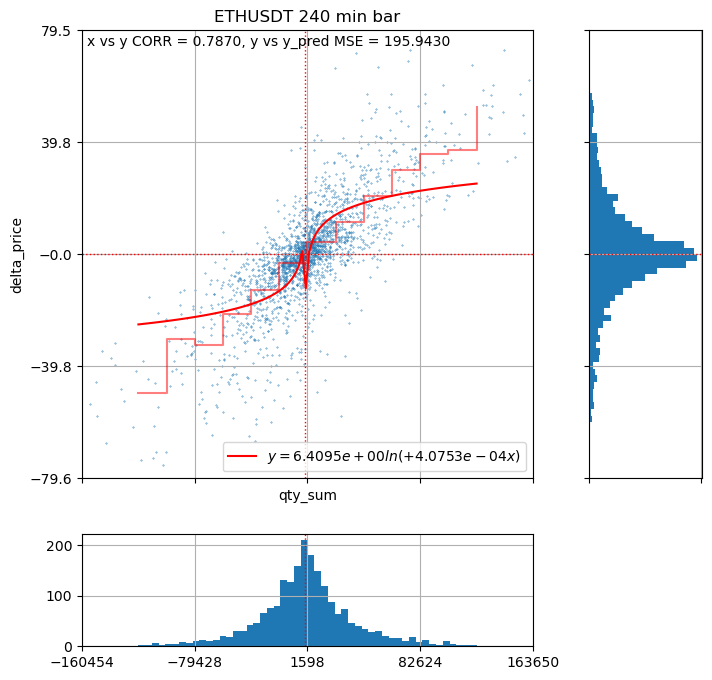

In [19]:
# タイムバーの売買インバランス対価格変化の散布図を作成し、後に使うパラメータb, cを計算する
# _popt[0]がb, _popt[1]がcに相当する
log_diff_price_upperlimit = np.percentile(df_timebar["log_diff_price"], 99.0)
log_diff_price_lowerlimit = np.percentile(df_timebar["log_diff_price"], 1.0)

_df_timebar_clipped = df_timebar.filter((pl.col("log_diff_price") >= log_diff_price_lowerlimit) & (pl.col("log_diff_price") <= log_diff_price_upperlimit))
x = _df_timebar_clipped["signed_volume"]
y = _df_timebar_clipped["delta_price"]

def func(x, a, b):
    return np.where(np.abs(x) < 1, 0, np.sign(x) * a * np.log(b * np.abs(x)))
func_str = "$y = %s ln(%s x)$"
#def func(x, a, b):
#    return a * x
#func_str = "$y = %s x + 0 * %s$"

popt, pcov = plot_correlation(x, y, func=func, func_label=func_str, title=f"{symbol} {interval_sec // 60} min bar", xaxis_label="qty_sum", yaxis_label="delta_price", legend_loc="best")
param_b = popt[0]
param_c = popt[1]

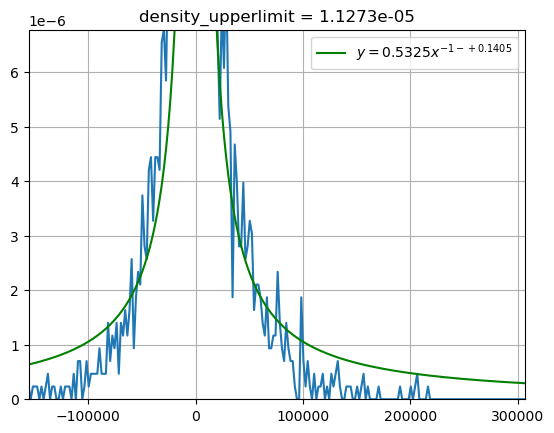

In [26]:
# タイムバーの売買インバランスの確率分布図を作成し、後に使うパラメータa, \alphaを計算する
# _popt[0]がa, _popt[1]が\alphaに相当する
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

array_signed_volume = np.histogram(_df_timebar_clipped["signed_volume"], bins=256, density=True)
density_upperlimit = np.quantile(array_signed_volume[0], 0.95)
df_histogram = pl.DataFrame({"signed_volume": array_signed_volume[1][:-1], "density": array_signed_volume[0]}).filter(pl.col("density") < density_upperlimit)

def func(x, a, b):
    #return a * np.power(x, -1-b)
    return a * np.power(np.abs(x), -1-b)
    
popt, pcov = curve_fit(func, df_histogram["signed_volume"], df_histogram["density"])

plt.plot(df_histogram["signed_volume"], df_histogram["density"])
plt.plot(df_histogram["signed_volume"], func(df_histogram["signed_volume"], *popt), color = 'green', label = '$y = %s x^{-1 - %s}$' % (f'{popt[0]:.4f}',  f'{popt[1]:+.4f}'))

plt.ylim(0, df_histogram["density"].quantile(0.95))
plt.xlim(df_histogram["signed_volume"].quantile(0.05), df_histogram["signed_volume"].quantile(0.95))
plt.title(f"density_upperlimit = {density_upperlimit:.4e}")
plt.grid()
plt.legend()

param_a = popt[0]
param_alpha = popt[1]

In [28]:
# bid / askヒット時間を計算するユーティリティ関数
# timestamp_toは含まない

_cache_date = None
_cache_df_trades = None

def calc_hit_time(timestamp_from, timestamp_to, bid_price, ask_price):
    global _cache_date, _cache_df_trades
    _bid_hit_time = np.nan
    _ask_hit_time = np.nan

    if np.isnan(bid_price) == True and np.isnan(ask_price) == True:
        return _bid_hit_time, _ask_hit_time

    _date = datetime.fromtimestamp(timestamp_from // 1000, timezone.utc).date()
    if _cache_date is not None and _cache_date == _date:
        _df_trades = _cache_df_trades
    else:
        _cache_df_trades = pl.read_parquet(f"/home/jovyan/work/binance_utility/trades/{symbol}_TRADES_{_date.year:04d}-{_date.month:02d}-{_date.day:02d}.parquet")
        _cache_date = _date
        _df_trades = _cache_df_trades
        
    _df_trades_filtered = _df_trades.filter((pl.col("timestamp") >= timestamp_from) & (pl.col("timestamp") < timestamp_to))
    _df_trades_less_than_bid_price = _df_trades_filtered.filter(pl.col("price") <= bid_price)
    if _df_trades_less_than_bid_price.shape[0] >= 1:
        _bid_hit_time = _df_trades_less_than_bid_price["timestamp"].min()
    
    _df_trades_more_than_ask_price = _df_trades_filtered.filter(pl.col("price") >= ask_price)
    if _df_trades_more_than_ask_price.shape[0] >= 1:
        _ask_hit_time = _df_trades_more_than_ask_price["timestamp"].min()
    
    return _bid_hit_time, _ask_hit_time

# Buyを実行するユーティリティ関数
def buy(q, cash, delta, position_abs_max, price, fee_rate):
    _q, _cash = q, cash
    if _q < position_abs_max:
        _delta = delta if q + delta <= position_abs_max else position_abs_max - _q
        #if _cash >= _delta * price:
        _q = q + _delta
        _cash = cash - (1 + fee_rate) * _delta * price
    return _q, _cash

# Sellを実行するユーティリティ関数
def sell(q, cash, delta, position_abs_max, price, fee_rate):
    _q, _cash = q, cash
    if _q > -position_abs_max:
        _delta = delta if q - delta >= -position_abs_max else np.abs(-position_abs_max - _q)
        _q = q - _delta
        _cash = cash + (1 - fee_rate) * _delta * price
    
    return _q, _cash

In [29]:
def simulation(gamma, df_timebar):
    # timebarデータフレームに計算した指値やポジション、損益を追加する
    initial_cash = 2000
    maker_fee_rate = 0.02 / 100
    taker_fee_rate = 0.04 / 100

    # 指値幅の計算パラメータ
    params = {
        "position_abs_max": 1,
        "lambda": 1 / interval_sec,
        "delta": 1,
        "a": param_a,
        "alpha": param_alpha,
        "b": param_b,
        "c": param_c,
        "gamma": gamma
    }

    params["A"] = params["lambda"] / params["alpha"] * params["a"] / params["c"]
    params["k"] = params["alpha"] / params["b"]
    params["1/k"] = 1 / params["k"]

    #print(json.dumps(params, indent=4, sort_keys=True))

    _df_timebar = df_timebar.with_columns([
        pl.lit(np.nan).alias("bid_delta"),
        pl.lit(np.nan).alias("ask_delta"),
        pl.lit(np.nan).alias("bid_price"),
        pl.lit(np.nan).alias("ask_price"),
        pl.lit(0).alias("trade_count"),
        pl.lit(0.0).alias("q"),
        pl.lit(0).alias("cash"),
        pl.lit(0.0).alias("value")])
    _df_timebar[0, "cash"] = initial_cash

    # シミュレーションの準備
    _prev_row = None

    # 指値幅の計算 (_qは_idxのものを使い、指値は_idx+1に入れる)
    _df_timebar_num_rows = _df_timebar.shape[0]
    with tqdm(range(0, _df_timebar_num_rows), position=0, leave=True) as _pbar:
        #for _idx in _pbar:
        for _idx in range(0, _df_timebar_num_rows):
            # このバーが始まった時点でのポジションとキャッシュを取得
            _q = _df_timebar[_idx, "q"]
            _cash = _df_timebar[_idx, "cash"]
            #_sigma = _df_timebar[_idx, "ewma_std"]
            _sigma = _df_timebar[_idx, "weighted_std"] * np.sqrt(7 * 6)

            # 最後の行は指値幅計算をしないwweighted_stdeighted_std
            if _idx < _df_timebar_num_rows - 1:
                _bid_delta = 1 / params["k"] + (2 * _q + params["delta"]) / 2 * np.sqrt((params["gamma"] * _sigma ** 2 * np.e) / (2 * params["A"] * params["delta"] * params["k"]))
                _ask_delta = 1 / params["k"] - (2 * _q - params["delta"]) / 2 * np.sqrt((params["gamma"] * _sigma ** 2 * np.e) / (2 * params["A"] * params["delta"] * params["k"]))
                #_gamma_delta = params["gamma"] * params["delta"]
                #_bid_delta = 1 / _gamma_delta * np.log(1 + _gamma_delta / params["k"]) + (2 * _q + params["delta"]) / 2 * np.sqrt((params["gamma"] * _sigma ** 2) / (2 * params["A"] * params["delta"] * params["k"]) * (1 + _gamma_delta / params["k"]) ** (params["k"] / _gamma_delta + 1))
                #_ask_delta = 1 / _gamma_delta * np.log(1 + _gamma_delta / params["k"]) - (2 * _q - params["delta"]) / 2 * np.sqrt((params["gamma"] * _sigma ** 2) / (2 * params["A"] * params["delta"] * params["k"]) * (1 + _gamma_delta / params["k"]) ** (params["k"] / _gamma_delta + 1))
                _df_timebar[_idx + 1, "bid_price"] = _df_timebar[_idx, "close"] - _bid_delta
                _df_timebar[_idx + 1, "ask_price"] = _df_timebar[_idx, "close"] + _ask_delta
                _df_timebar[_idx + 1, "bid_delta"] = _bid_delta
                _df_timebar[_idx + 1, "ask_delta"] = _ask_delta
                

            # 最初の行は指値幅がないのでトレードの計算をしない                                
            if _idx == 0:
                _df_timebar[_idx+1, "q"] = _q
                _df_timebar[_idx+1, "cash"] = _cash
                _df_timebar[_idx+1, "value"] = _cash + _q * _df_timebar[_idx, "close"]
                continue
            
            # _idx-1で計算され、_idxに入っている指値をもとにヒットを計算する
            _is_bid_hit = _df_timebar[_idx, "bid_price"] >= _df_timebar[_idx, "low"]
            _is_ask_hit = _df_timebar[_idx, "ask_price"] <= _df_timebar[_idx, "high"]

            if _is_bid_hit and _is_ask_hit:
                _current_timestamp = _df_timebar[_idx, "timestamp"]
                _bid_hit_timestamp, _ask_hit_timestamp = calc_hit_time(_current_timestamp, _current_timestamp + interval_sec * 1000, _df_timebar[_idx, "bid_price"], _df_timebar[_idx, "ask_price"])
                if _bid_hit_timestamp <= _ask_hit_timestamp:
                    #print(f"maker buy then maker sell : origin = {_q}, {_cash}")
                    _q, _cash = buy(_q, _cash, params["delta"], params["position_abs_max"], _df_timebar[_idx, "bid_price"], maker_fee_rate)
                    #print(f"after maker buy : {_q}, {_cash}")
                    _q, _cash = sell(_q, _cash, params["delta"], params["position_abs_max"], _df_timebar[_idx, "ask_price"], maker_fee_rate)
                    #print(f"after maker sell : {_q}, {_cash}")
                    _df_timebar[_idx, "trade_count"] = 2
                else:
                    #print(f"maker sell then maker buyl : origin = {_q}, {_cash}")
                    _q, _cash = sell(_q, _cash, params["delta"], params["position_abs_max"], _df_timebar[_idx, "ask_price"], maker_fee_rate)
                    #print(f"after maker sell : {_q}, {_cash}")
                    _q, _cash = buy(_q, _cash, params["delta"], params["position_abs_max"], _df_timebar[_idx, "bid_price"], maker_fee_rate)
                    #print(f"after maker buy : {_q}, {_cash}")
                    _df_timebar[_idx, "trade_count"] = 2
            elif _is_bid_hit:
                #print(f"maker buy and taker sell : origin = {_q}, {_cash}")
                _q, _cash = buy(_q, _cash, params["delta"], params["position_abs_max"], _df_timebar[_idx, "bid_price"], maker_fee_rate)
                #print(f"after maker buy : {_q}, {_cash}")
                _q, _cash = sell(_q, _cash, params["delta"], params["position_abs_max"], _df_timebar[_idx, "close"], taker_fee_rate)
                #print(f"after taker sell : {_q}, {_cash}")
                _df_timebar[_idx, "trade_count"] = 2
            elif _is_ask_hit:
                #print(f"maker sell and taker buy : origin = {_q}, {_cash}")
                _q, _cash = sell(_q, _cash, params["delta"], params["position_abs_max"], _df_timebar[_idx, "ask_price"], maker_fee_rate)
                #print(f"after maker sell : {_q}, {_cash}")
                _q, _cash = buy(_q, _cash, params["delta"], params["position_abs_max"], _df_timebar[_idx, "close"], taker_fee_rate)
                #print(f"after taker buy : {_q}, {_cash}")
                _df_timebar[_idx, "trade_count"] = 2
            
            # Valueの計算などを行い、現タイムバー完了時点のタイムバーのq, cash, valueを_idx+1に代入しておく
            # 最後の行はこの計算をしない
            if _idx < _df_timebar_num_rows - 1:
                _df_timebar[_idx+1, "q"] = _q
                _df_timebar[_idx+1, "cash"] = _cash
                _df_timebar[_idx+1, "value"] = _cash + _q * _df_timebar[_idx, "close"]
                #_pbar.set_description(f"value={_df_timebar[_idx+1, 'value']:07.2f}")
    
    _df_timebar = _df_timebar.with_columns((np.log(pl.col("value")) - np.log(pl.col("value").shift(1))).alias("logreturn"))
    _df_timebar = _df_timebar.with_columns(pl.when(pl.col("logreturn").is_infinite()).then(None).otherwise(pl.col("logreturn")).keep_name())
    _return = _df_timebar["logreturn"].mean()
    _risk = _df_timebar["logreturn"].std()
    _sr = _return / _risk if np.isnan(_risk) == False and np.isnan(_return) == False and _risk != 0 else 0

    print(f"gamma = {gamma}, SR = {_sr}, final_value = {_df_timebar[-1, 'value']}, trade_count = {_df_timebar['trade_count'].sum()}")
    return _df_timebar, _sr

def objective(trial):
    global df_timebar
    
    # BTCUSDT 3.275286430042483e-05 with weighted_std * np.sqrt(7*6)
    _gamma = trial.suggest_float(low=0.0, high=0.001, name="gamma")
    _df_timebar, _sr = simulation(_gamma, df_timebar)

    # 表示用データフレームの作成
    _df_timebar_pd = _df_timebar.to_pandas().dropna()
    _df_timebar_pd["datetime"] = pd.to_datetime(_df_timebar_pd["timestamp"], unit="ms")
    _df_timebar_pd = _df_timebar_pd.set_index("datetime", drop = True)
    #display(df_timebar_pd)
    _df_timebar_pd_filtered = _df_timebar_pd[(_df_timebar_pd.index >= "2022-5-1") & (_df_timebar_pd.index <= "2023-6-1")]

    # プロット
    additional_plot = [mpf.make_addplot(
        _df_timebar_pd_filtered["value"], type="line", color="green", ylabel="Value", width=1, panel=2),
        #mpf.make_addplot(df_timebar_pd_filtered["q"], type="line", color="green", ylabel="position", width=1, panel=3),
        mpf.make_addplot(_df_timebar_pd_filtered["bid_price"], type="line", color="blue", width=0.2),
        mpf.make_addplot(_df_timebar_pd_filtered["ask_price"], type="line", color="red", width=0.2),
        mpf.make_addplot(_df_timebar_pd_filtered["weighted_std"] * np.sqrt(7*6), type="line", color="red", ylabel="\sigma", width=0.2, panel = 3)]
    mpf.plot(_df_timebar_pd_filtered, type="candle", title=f"{symbol} MM strategy", ylabel="Price", style="yahoo", figsize=(12, 6), addplot = additional_plot, volume=True, warn_too_much_data=int(365*24*24/2))
        

    return _sr

[I 2023-05-28 13:57:15,046] A new study created in memory with name: no-name-8eb08f5a-77fb-4c65-94ef-83a5178648f0
  0%|          | 0/2184 [00:01<?, ?it/s]
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


gamma = 0.07415017820159608, SR = 0.024859765202502132, final_value = 2117.0, trade_count = 44


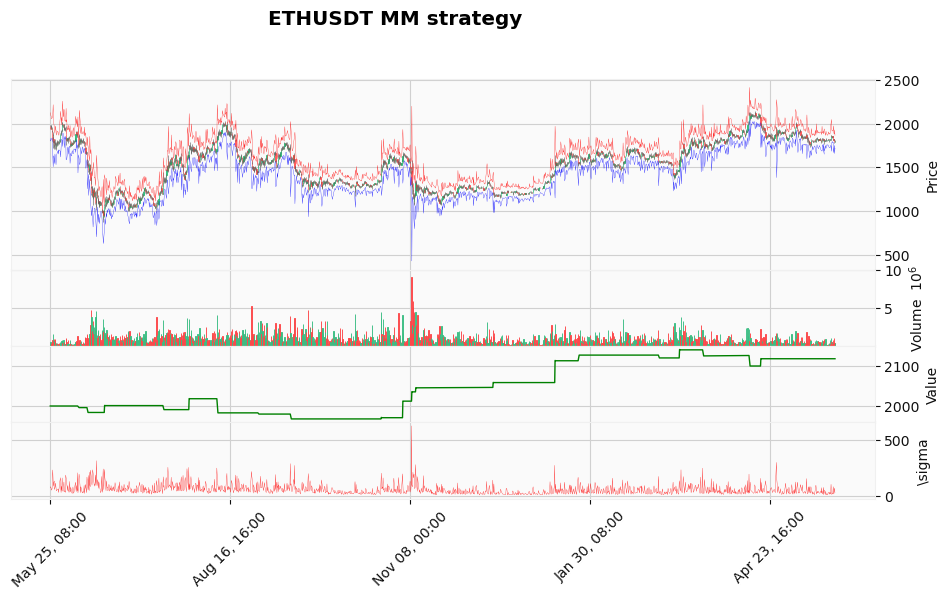

[I 2023-05-28 13:57:19,675] Trial 0 finished with value: 0.024859765202502132 and parameters: {'gamma': 0.07415017820159608}. Best is trial 0 with value: 0.024859765202502132.
  0%|          | 0/2184 [00:01<?, ?it/s]
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


gamma = 0.2165884686680566, SR = 0.02946129986747909, final_value = 2163.0, trade_count = 16


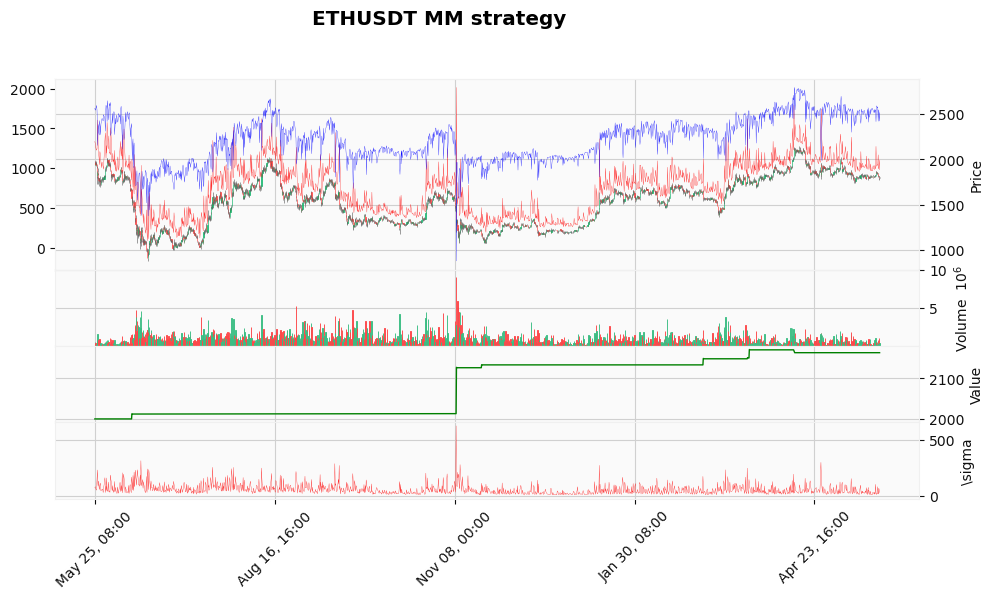

[I 2023-05-28 13:57:24,289] Trial 1 finished with value: 0.02946129986747909 and parameters: {'gamma': 0.2165884686680566}. Best is trial 1 with value: 0.02946129986747909.
  0%|          | 0/2184 [00:01<?, ?it/s]
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


gamma = 0.03768324917196164, SR = 0.020665400353674118, final_value = 2140.0, trade_count = 88


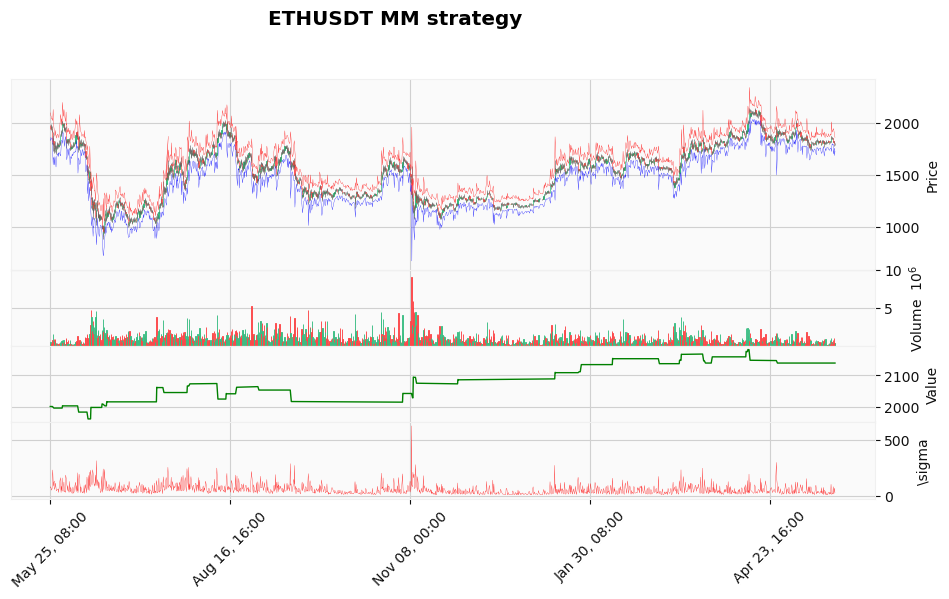

[I 2023-05-28 13:57:29,214] Trial 2 finished with value: 0.020665400353674118 and parameters: {'gamma': 0.03768324917196164}. Best is trial 1 with value: 0.02946129986747909.
  0%|          | 0/2184 [00:01<?, ?it/s]
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


gamma = 0.8606397647026004, SR = 0, final_value = 2000.0, trade_count = 0


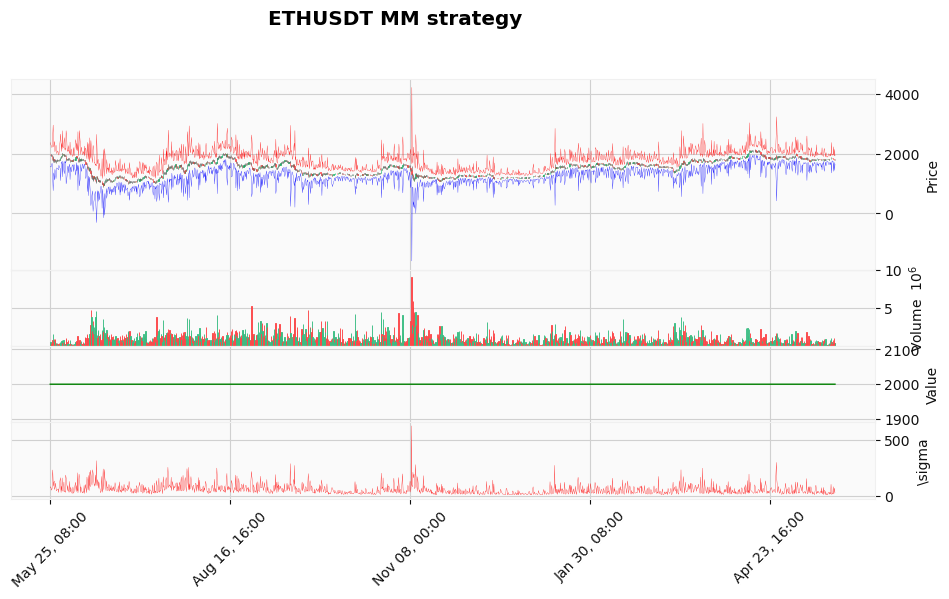

[I 2023-05-28 13:57:33,917] Trial 3 finished with value: 0.0 and parameters: {'gamma': 0.8606397647026004}. Best is trial 1 with value: 0.02946129986747909.
  0%|          | 0/2184 [00:01<?, ?it/s]
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


gamma = 0.5125590335716913, SR = 0.02735226121842205, final_value = 2062.0, trade_count = 4


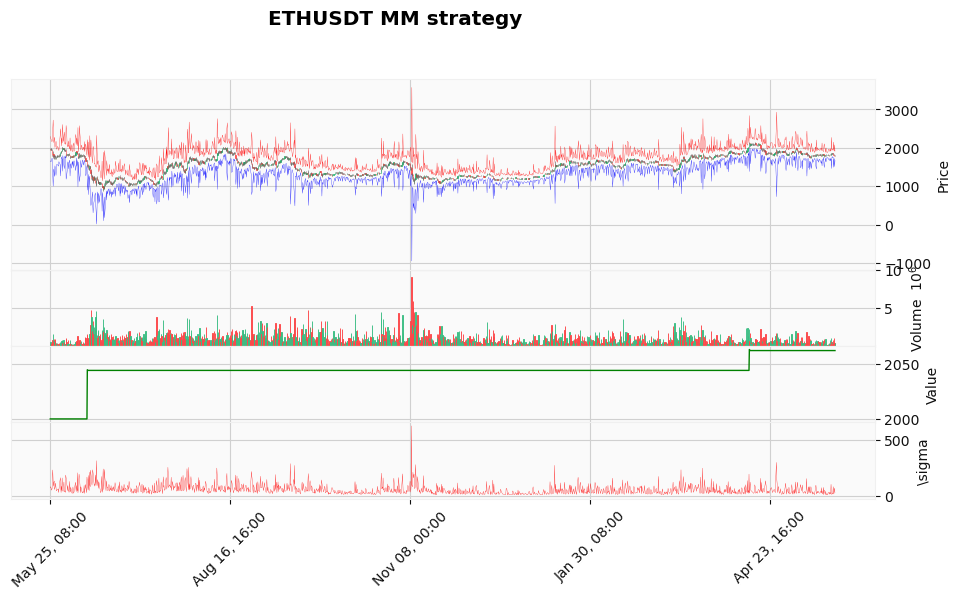

[I 2023-05-28 13:57:38,927] Trial 4 finished with value: 0.02735226121842205 and parameters: {'gamma': 0.5125590335716913}. Best is trial 1 with value: 0.02946129986747909.
  0%|          | 0/2184 [00:01<?, ?it/s]
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


gamma = 0.6120949570411153, SR = 0.020857032594493282, final_value = 2025.0, trade_count = 2


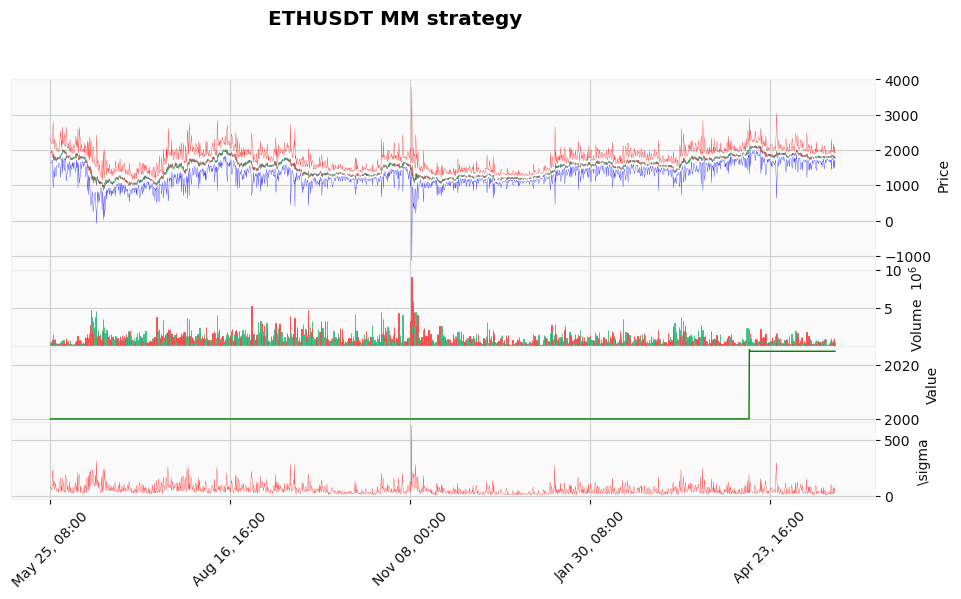

[I 2023-05-28 13:57:43,655] Trial 5 finished with value: 0.020857032594493282 and parameters: {'gamma': 0.6120949570411153}. Best is trial 1 with value: 0.02946129986747909.
  0%|          | 0/2184 [00:01<?, ?it/s]
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


gamma = 0.28316066949326435, SR = 0.03921480406181869, final_value = 2066.0, trade_count = 10


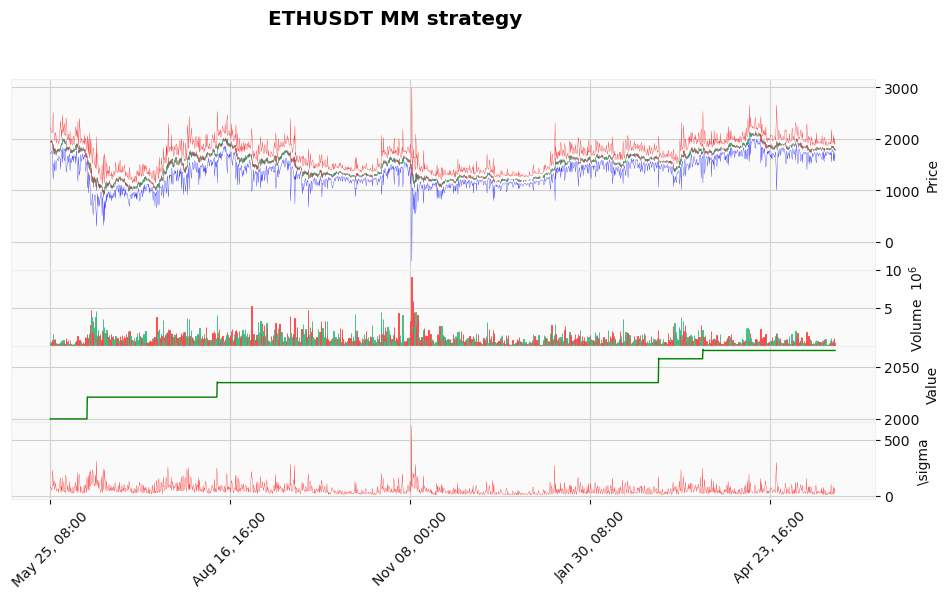

[I 2023-05-28 13:57:48,346] Trial 6 finished with value: 0.03921480406181869 and parameters: {'gamma': 0.28316066949326435}. Best is trial 6 with value: 0.03921480406181869.
  0%|          | 0/2184 [00:01<?, ?it/s]
/opt/conda/lib/python3.10/site-packages/polars/series/series.py:1023: RuntimeWarning: divide by zero encountered in log
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


gamma = 0.534168511911925, SR = 0.020915033197673905, final_value = 2020.0, trade_count = 2


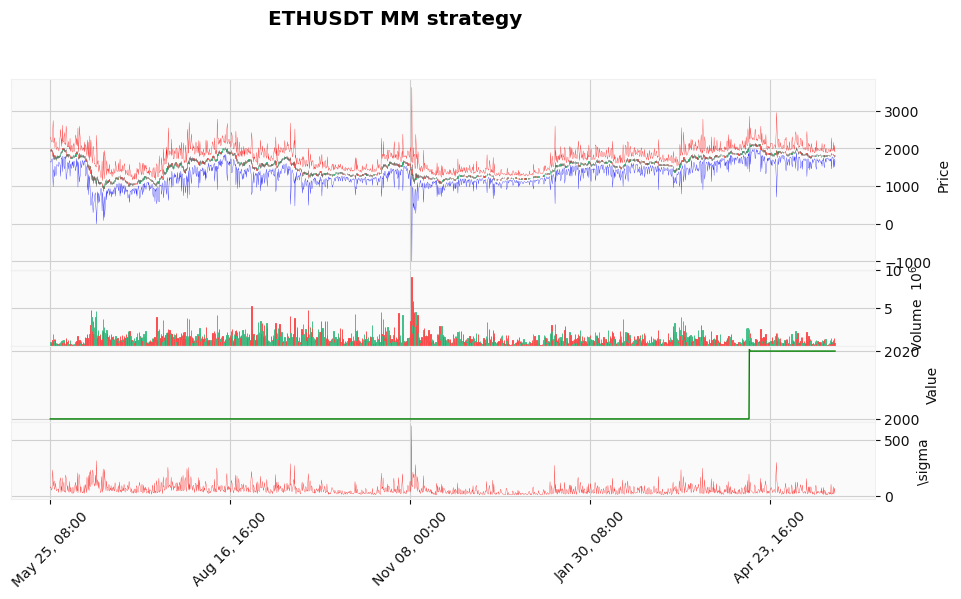

[I 2023-05-28 13:57:53,592] Trial 7 finished with value: 0.020915033197673905 and parameters: {'gamma': 0.534168511911925}. Best is trial 6 with value: 0.03921480406181869.
  0%|          | 0/2184 [00:00<?, ?it/s]

In [30]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 100)